In [12]:
import numpy as np
import pandas as pd

In [13]:
dataset = pd.read_csv("data.csv", encoding='ISO-8859-1')

In [14]:
dataset

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom
...,...,...,...,...,...,...
397759,571203,23408,PHOTO FRAME LINEN AND LACE SMALL,6,2.08,United Kingdom
397760,571203,23453,OVAL MINI PORTRAIT FRAME,8,1.95,United Kingdom
397761,571203,85099B,JUMBO BAG RED RETROSPOT,100,1.79,United Kingdom
397762,571203,20727,LUNCH BAG BLACK SKULL.,100,1.45,United Kingdom


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Check for missing values and fill them
dataset['Quantity'].fillna(dataset['Quantity'].mean(), inplace=True)
dataset['UnitPrice'].fillna(dataset['UnitPrice'].mean(), inplace=True)

# Calculate total monetary value for each transaction
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']
dataset['TotalPrice'].fillna(dataset['TotalPrice'].mean(), inplace=True)

# Assume current_date for the example
current_date = dt.datetime(2024, 8, 1)

/tmp/ipykernel_2817/2301365445.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Quantity'].fillna(dataset['Quantity'].mean(), inplace=True)
/tmp/ipykernel_2817/2301365445.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [16]:

# Convert InvoiceNo to a string (in case it's read as a number)
dataset['InvoiceNo'] = dataset['InvoiceNo'].astype(str)

# Fill missing InvoiceDate with the current date
if 'InvoiceDate' in dataset.columns:
    dataset['InvoiceDate'].fillna(current_date, inplace=True)
else:
    dataset['InvoiceDate'] = current_date


In [25]:
#Create an RFM table without causing the 'already exists' error
rfm = dataset.groupby('InvoiceNo').agg({
    'InvoiceDate': lambda date: (current_date - date.max()).days,  # Recency
    'TotalPrice': 'sum'  # Monetary value
}).reset_index()

# Add Frequency manually, as it's just the count of transactions for each InvoiceNo
rfm['Frequency'] = dataset.groupby('InvoiceNo').size().values

# Rename columns to represent RFM features
rfm.columns = ['InvoiceNo', 'Recency', 'Monetary', 'Frequency']

# Handle missing values in the RFM table
rfm['Recency'].fillna(rfm['Recency'].mean(), inplace=True)
rfm['Monetary'].fillna(rfm['Monetary'].mean(), inplace=True)
rfm['Frequency'].fillna(rfm['Frequency'].mean(), inplace=True)

# Drop the InvoiceNo column as it is not needed for clustering
rfm = rfm.drop('InvoiceNo', axis=1)


/tmp/ipykernel_2817/1182632691.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm['Recency'].fillna(rfm['Recency'].mean(), inplace=True)
/tmp/ipykernel_2817/1182632691.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [18]:
# Normalize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)


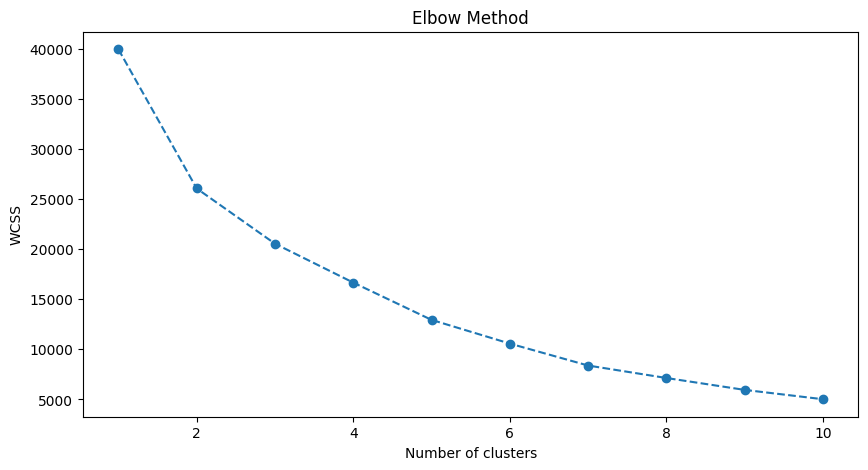

         Recency      Monetary   Frequency
Cluster                                   
0            0.0    170.712381    9.360433
1            0.0   2366.751754  259.817544
2            0.0    933.897970   53.354496
3            0.0  15124.548421   57.859649


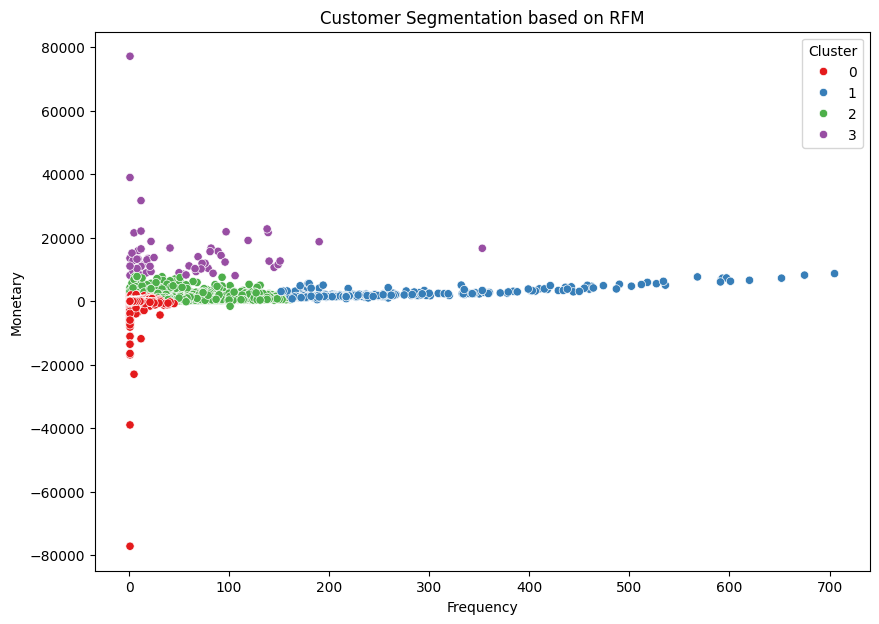

In [19]:

# Plot the Elbow graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with the chosen number of clusters
optimal_clusters = 4  
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze the clusters
print(rfm.groupby('Cluster').mean())

# Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='Set1')
plt.title('Customer Segmentation based on RFM')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()


In [20]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.6345400578780723


In [21]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 0.7222686820910958


In [22]:
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(rfm_scaled, rfm['Cluster'])
print(f'Calinski-Harabasz Index: {ch_index}')


Calinski-Harabasz Index: 9313.759350186956


In [23]:
dataset

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,TotalPrice,InvoiceDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2024-08-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2024-08-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2024-08-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2024-08-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2024-08-01
...,...,...,...,...,...,...,...,...
397759,571203,23408,PHOTO FRAME LINEN AND LACE SMALL,6,2.08,United Kingdom,12.48,2024-08-01
397760,571203,23453,OVAL MINI PORTRAIT FRAME,8,1.95,United Kingdom,15.60,2024-08-01
397761,571203,85099B,JUMBO BAG RED RETROSPOT,100,1.79,United Kingdom,179.00,2024-08-01
397762,571203,20727,LUNCH BAG BLACK SKULL.,100,1.45,United Kingdom,145.00,2024-08-01


In [28]:
rfm.dtypes

Recency        int64
Monetary     float64
Frequency      int64
dtype: object

In [29]:
rfm

,Recency,Monetary,Frequency
0,0,139.12,7
1,0,22.20,2
2,0,278.73,12
3,0,70.05,4
4,0,17.85,1
...,...,...,...
19984,0,-48.33,6
19985,0,-13.56,4
19986,0,-60.84,1
19987,0,-8.50,1


In [27]:
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']